<a href="https://colab.research.google.com/github/alekshex/Nengo/blob/main/nengo_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet nengo-dl

In [2]:
import nengo
import nengo_dl
import numpy as np
import tensorflow as tf
from numpy import loadtxt
import requests, zipfile, io
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sc = MinMaxScaler()

In [3]:
def MSE(truth, pred):
    return mean_squared_error(truth, pred) #sklearn

In [4]:
def LoadData(normalize = False):
    global sc
    # load the dataset

    r = requests.get( 'https://onedrive.live.com/download?cid=4C6D662DBB55C64C&resid=4C6D662DBB55C64C%21117&authkey=AIRxB8r0Xvit9yM' ) 
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    
    dataset = loadtxt("DATA_FILE", delimiter=',')
    #print(len(dataset))

    NUM_OF_SAMPLES = len(dataset)
    NUM_OF_TRAINING_SAMPLES = int(NUM_OF_SAMPLES * 0.7)
    DATA_VALIDATION_PERCENT=0.15
    NUM_OF_VALIDATION_SAMPLES = int(NUM_OF_SAMPLES * DATA_VALIDATION_PERCENT)
  
    allDataXNonNorm = dataset[:,0:3]
    allDataYNonNorm = dataset[:,3:8]
    # split into input and output variables
    EEData = dataset[0:NUM_OF_TRAINING_SAMPLES,0:3] 
    YData = dataset[0:NUM_OF_TRAINING_SAMPLES,3:8] 

    EEDataValidation = dataset[NUM_OF_TRAINING_SAMPLES:NUM_OF_TRAINING_SAMPLES + \
                                        NUM_OF_VALIDATION_SAMPLES,0:3] 
    YDataValidation = dataset[NUM_OF_TRAINING_SAMPLES:NUM_OF_TRAINING_SAMPLES + \
                                   NUM_OF_VALIDATION_SAMPLES,3:8]   

    EEDataTest = dataset[NUM_OF_TRAINING_SAMPLES+NUM_OF_VALIDATION_SAMPLES:,0:3]
    YDataTest = dataset[NUM_OF_TRAINING_SAMPLES+NUM_OF_VALIDATION_SAMPLES:,3:8]    

    if normalize:     #Normalizing the data
        sc.fit(allDataXNonNorm) 
        EEDataNormalized = sc.transform(EEData) 
        EEDataValidationNormalized = sc.transform(EEDataValidation)
        EEDataTestNormalized = sc.transform(EEDataTest) #only transform   
        
        sc.fit(allDataYNonNorm) 
        YDataNormalized = sc.transform(YData)
        YDataValidationNormalized = sc.transform(YDataValidation)       
        YDataTestNormalized = sc.transform(YDataTest) 
    else:
        EEDataNormalized = EEData
        EEDataValidationNormalized = EEDataValidation
        EEDataTestNormalized = EEDataTest
        
        YDataNormalized = YData
        YDataValidationNormalized = YDataValidation
        YDataTestNormalized = YDataTest

    return EEDataNormalized, YDataNormalized, \
           EEDataValidationNormalized, YDataValidationNormalized, \
           EEDataTestNormalized, YDataTestNormalized, \
           EEDataTest, YDataTest, \
           dataset #not normalized

In [5]:
def ConstructNetworkAllInOne(inputTrain,outputTrain,inputValidation,outputValidation,inputTest,outputTest):
    steps = 1
    inputTrainNgo = np.tile(inputTrain[:, None, :], (1, steps, 1))
    outputTrainNgo = np.tile(outputTrain[:, None, :], (1, steps, 1))
    inputValidationNgo = np.tile(inputValidation[:, None, :], (1, steps, 1))
    outputValidationNgo = np.tile(outputValidation[:, None, :], (1, steps, 1))
    inputTestNgo = np.tile(inputTest[:, None, :], (1, steps, 1))
    outputTestNgo = np.tile(outputTest[:, None, :], (1, steps, 1))

    input = tf.keras.Input(shape=(3,))
    l1 = tf.keras.layers.Dense(50,activation=tf.nn.relu)(input)
    l2 = tf.keras.layers.Dense(50,activation=tf.nn.relu)(l1)
    output = tf.keras.layers.Dense(5,activation=tf.nn.relu)(l2)
    
    model = tf.keras.Model(inputs=input, outputs=output)

    model.summary()


    converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: nengo.RectifiedLinear()},
     )
    net = converter.net
    nengo_input = converter.inputs[input]
    nengo_output = converter.outputs[output]
    nengo_prob1 = converter.layers[l1]


    # run training
    with nengo_dl.Simulator(net, minibatch_size=100, seed=0) as sim:
        sim.compile(
            optimizer=tf.optimizers.SGD(),
            loss={nengo_output: tf.losses.mse},
        )
        

        sim.fit(
            inputTrainNgo, {nengo_output: outputTrainNgo},
            validation_data=(inputValidationNgo, outputValidationNgo),
            epochs=100,
        )
        sim.save_params("./nengo-model-relu-1")     
    
    return model,inputTestNgo


In [14]:
def RunNetwork(
    model, 
    inputTest, 
    outputTest,
    activation,
    params_file="./nengo-model-relu-1",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=15000,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse=synapse,
    )

    inputLayer = model.get_layer('input_1')
    hiddenLayer1 = model.get_layer('dense')
    outputLayer = model.get_layer('dense_2')

    # get input/output objects
    nengo_input = nengo_converter.inputs[inputLayer]
    nengo_output = nengo_converter.outputs[outputLayer]

    # add a probe to the first  layer to record activity.
    # we'll only record from a subset of neurons, to save memory.
    sample_neurons = np.linspace(
        0,
        np.prod(hiddenLayer1.output_shape[1:]),
        100,
        endpoint=False,
        dtype=np.int32,
    )
    with nengo_converter.net:
        probe_l1 = nengo.Probe(nengo_converter.layers[hiddenLayer1][sample_neurons])

    # repeat inputs for some number of timesteps
    testInputData = np.tile(inputTest[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test
    with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=100, progress_bar=False
    ) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: testInputData})

    # compute accuracy on test data, using output of network on
    # last timestep
    # predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    # accuracy = (predictions == outputTest[:n_test,0]).mean()
    # print("Test accuracy: %.2f%%" % (100 * accuracy))
    mse = MSE(outputTest[:n_test], data[nengo_output][:n_test, -1]) #normalized comparison
    print('\nMSE Nengo run net prediction of {} samples: {}\n\n'.format(n_test, mse))    

    # plot the results
    for ii in range(3):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        scaled_data = data[probe_l1][ii] * scale_firing_rates
        if isinstance(activation, nengo.SpikingRectifiedLinear):
            scaled_data *= 0.001
            rates = np.sum(scaled_data, axis=0) / (n_steps * nengo_sim.dt)
            plt.ylabel("Number of spikes")
        else:
            rates = scaled_data
            plt.ylabel("Firing rates (Hz)")
        plt.xlabel("Timestep")
        plt.title(
            "Neural activities (conv0 mean=%dHz max=%dHz)" % (rates.mean(), rates.max())
        )
        plt.plot(scaled_data)

        plt.subplot(1, 3, 2)
        plt.title("Output predictions")
        plt.plot(tf.nn.softmax(data[nengo_output][ii]))
        plt.legend([str(j) for j in range(10)], loc="upper left")
        plt.xlabel("Timestep")
        plt.ylabel("Probability")

        plt.tight_layout()    



In [7]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

inputTrain, outputTrain, inputValidation, outputValidation, inputTest, outputTest,\
 eeTestDataNonNorm, eeTestYNonNorm, allDataNonNorm = LoadData(True)

NNa, inputTestNgo = ConstructNetworkAllInOne(inputTrain,outputTrain,inputValidation,outputValidation,inputTest,outputTest) 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 50)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 255       
Total params: 3,005
Trainable params: 3,005
Non-trainable params: 0
_________________________________________________________________
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/10


MSE Nengo run net prediction of 15000 samples: 0.004094903981140077




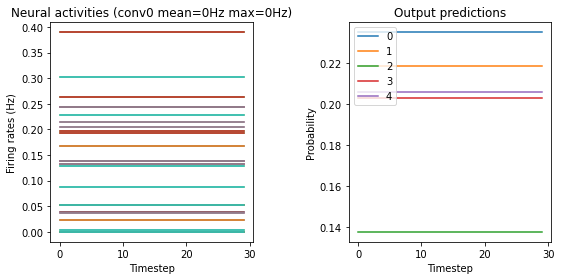

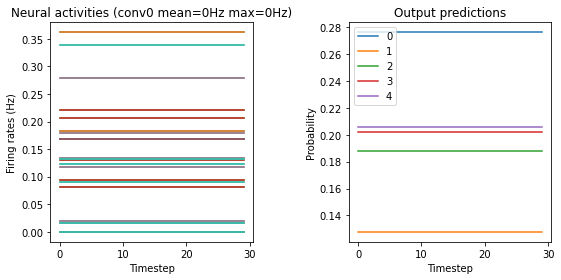

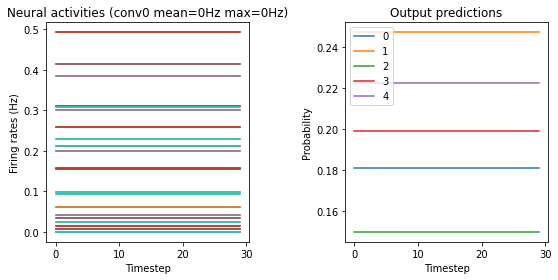

In [17]:
RunNetwork(
    NNa,
    inputTestNgo,
    outputTest,        
    activation=nengo.RectifiedLinear(), 
    params_file="./nengo-model-relu-1",
    #n_steps=10,
)


MSE Nengo run net prediction of 15000 samples: 0.18198264030290198




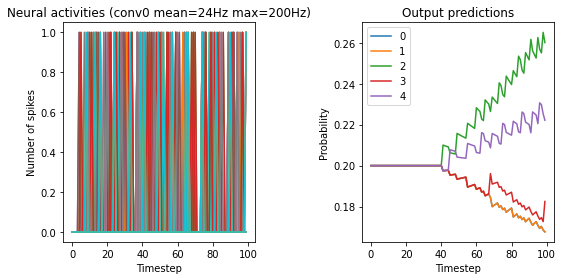

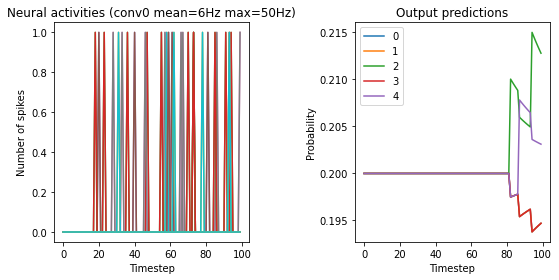

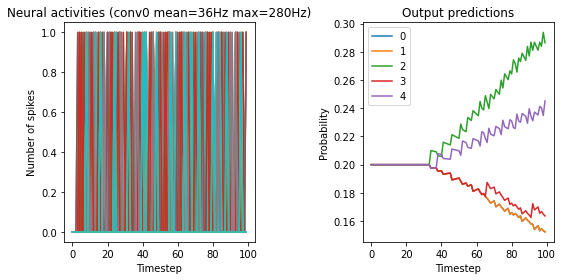

In [73]:
RunNetwork(
    NNa,
    inputTestNgo,
    outputTest,        
    activation=nengo.SpikingRectifiedLinear(), 
    params_file="./nengo-model-relu-1",
    n_steps=100,
    synapse=0.032,
    scale_firing_rates=500,
    #n_test=100
)